# Игры — Формирование модели монетизации

### Постановка цели

**Цель исследования** - сформировать новую модель монетизации мобильной игры `Космические братья`

Стоит учитывать хрупкий баланс между заработком с рекламы и уровнем удовлетворенности пользователей:
- Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
- Но чем позже создатели игры включат рекламу, тем меньше они заработают. 

### Декомпозиция проекта

В проекте нужно определить оптимальное время для запуска рекламы. 

Распишем последовательность выполнения проекта для достижения поставленной цели:
* Загрузка данных, их изучение и предобработка.


* Проведение исследовательского анализа данных:
    * Сравнить количество побед над первым противником и реализацией проектов по разработке орбитальной сборки спутников, чтобы определить, каким образом игроки чаще всего заканчивают первый уровень.
    * Узнать, сколько игрокам в среднем требуется построить зданий (и каких) для победы над первым противником или для завершения проекта.
    * Определить, какие источники привлекают больше всего пользователей и какие из них наиболее выгодны в расчёте на одного привлеченного клиента. 
    
    
* Расчёт прибыли для модели показа рекламы на экране выбора постройки при учёте прибыльности одного показа в 0.07 единиц. Сравнение прибыли с пользователей, привлеченных разными источниками. 
    

* Проверка статистических гипотез:

    1 - Гипотеза о различии времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.
    
    2 - Гипотеза о различии дохода с пользователей, привлеченных источниками `facebook_ads` и `youtube_channel_reklama`.
    
    
* Подведение итогов по проекту.


* Создание дашборда.


* Оформление презентации по проекту.

### Описание данных

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

**Датасет - game_actions**

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

**Датасет - ad_cost**

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

**Датасет - user_source**

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

# Материалы

`Дашборд` - https://public.tableau.com/app/profile/dmitriy5709/viz/Final_project_dashboard_16599597062410/Dashboard1?publish=yes

## Загрузка данных и подготовка их к анализу

### Загрузка и обзор данных

In [1]:
#Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns
import plotly.express as px
from itertools import combinations
from scipy import stats as st

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# загружаем файлы в переменные и выводим на экран первые 5 строк
ad_costs = pd.read_csv('D:/Datasets/final/ad_costs.csv')
game_actions = pd.read_csv('D:/Datasets/final/game_actions.csv')
user_source = pd.read_csv('D:/Datasets/final/user_source.csv')

main_tables = [game_actions, ad_costs, user_source]

for table in main_tables:
    display(table.head())

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Посмотрим данные подробнее

In [3]:
for table in main_tables:
    display(table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

Практически все столбцы в таблицах имеют тип `object`, только в столбце cost таблицы ad_costs тип `float`.

Есть пропуски в столбцах `building_type` и `project_type` таблицы game_actions. Посмотрим их подробнее.

In [4]:
game_actions[game_actions['building_type'].isna()]

,event_datetime,event,building_type,user_id,project_type
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN
...,...,...,...,...,...
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


In [5]:
game_actions.query('event != "building"')['event'].count()

7683

По пропускам в столбце `building_type` можем сделать вывод, что пропуски являются те события, когда игроки не строили зданий, то есть события выполнения проекта или завершения уровня

In [6]:
game_actions.query('event == "project"')

,event_datetime,event,building_type,user_id,project_type
47121,2020-05-08 18:10:25,project,NaN,e3c66498-9d45-4000-9392-f81e6796e7da,satellite_orbital_assembly
57398,2020-05-09 13:49:11,project,NaN,936e7af6-8338-4703-a1df-fc6c3f5b8e34,satellite_orbital_assembly
58797,2020-05-09 16:19:33,project,NaN,a4491c86-c498-4f74-a56e-65c136d0e9a1,satellite_orbital_assembly
61174,2020-05-09 20:29:01,project,NaN,85d9e675-562b-4329-8bbd-14d3b39096be,satellite_orbital_assembly
63770,2020-05-10 00:57:47,project,NaN,1889ca71-3c57-4e61-9ea6-a711971bbf0a,satellite_orbital_assembly
...,...,...,...,...,...
135602,2020-06-02 03:04:42,project,NaN,9d98001c-7e14-40d7-896e-46b3047365fd,satellite_orbital_assembly
135603,2020-06-02 06:21:03,project,NaN,df4a1e13-eba9-4928-a7cf-ee303d6f80f9,satellite_orbital_assembly
135609,2020-06-02 17:17:28,project,NaN,82e46f34-e243-4728-8e20-2e171fc33ea4,satellite_orbital_assembly
135617,2020-06-03 09:46:04,project,NaN,fe032991-71e0-48c5-889f-4c3805ba4c9b,satellite_orbital_assembly


In [7]:
game_actions.query('event != "project"').tail()

,event_datetime,event,building_type,user_id,project_type
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


А вот и все наши события с проектами! Все остальные пропуски в колонке `project_type` логично объясняются тем, что событие проекта просто не происходило

### Предобработка данных

#### Обработка дубликатов

Обработаем явные дубликаты в таблицах game_actions и user_source

In [8]:
print('Количество дубликатов в таблице game_actions:', game_actions.duplicated().sum())
print('Количество дубликатов в таблице user_source:', user_source.duplicated().sum())

Количество дубликатов в таблице game_actions: 1
Количество дубликатов в таблице user_source: 0


Удалим найденный дубликат:

In [9]:
game_actions = game_actions.drop_duplicates()

Теперь посмотрим на неявные дубликаты в тех же таблицах 

In [10]:
display(game_actions[game_actions[['event_datetime', 'user_id']].duplicated()])
user_source[user_source['user_id'].duplicated()]

,event_datetime,event,building_type,user_id,project_type


,user_id,source


**Вывод**

Неявные дубликаты не найдены, а явные обработаны

#### Изменение типов данных

Изменим тип данных в столбце event_datetime  на `datetime`

In [11]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

### Обработка пропусков

Заполним пропуски в колонках `building_type` и `project_type` значениями None, чтобы в дальнейшем было проще вести анализ

In [12]:
game_actions['building_type'] = game_actions['building_type'].fillna('None')
game_actions['project_type'] = game_actions['project_type'].fillna('None')

## Исследовательский анализ данных

### Анализ игроков, завершивших первый уровень

Сравним количество побед над первым противником и реализацией проектов по разработке орбитальной сборки спутников, чтобы определить, каким образом игроки чаще всего заканчивают первый уровень.

In [13]:
finished_users_cnt = game_actions.query('event == "finished_stage_1"')['event'].count()
finished_by_project_cnt = game_actions.query('event == "project"')['event'].count()
finished_by_victory_cnt = finished_users_cnt  - finished_by_project_cnt

print('Количество пользователей, закончивших через проект: {} ({:.2%})'.format(finished_by_project_cnt, finished_by_project_cnt/finished_users_cnt))
print('Количество пользователей, закончивших через победу над первым противником: {} ({:.2%})'.format(finished_by_victory_cnt, finished_by_victory_cnt/finished_users_cnt))

Количество пользователей, закончивших через проект: 1866 (32.08%)
Количество пользователей, закончивших через победу над первым противником: 3951 (67.92%)


**Выводы**

Большинство пользователей заканчивают уровень через победу над первым противником, таких пользователей 68% от общего числа успешно завершивших уровень.

### Сколько игрокам требуется построить зданий для завершения уровня

Узнаем, сколько игрокам в среднем требуется построить зданий (и каких) для победы над первым противником или для завершения проекта

Сделаем предположение, что игроки в большинстве случаев не строили больше зданий после завершения проекта или победы над первым противником, а сразу переходили на новый уровень

In [14]:
#нахожу id игроков, закончивших первый уровень
finished_users_id = game_actions.query('event == "finished_stage_1"')['user_id']

#нахожу id игроков, завершивших проект, затем создаю датасет, где будут все эти игроки
finished_by_project_id = game_actions.query('event == "project"')['user_id']
finished_by_project = game_actions[game_actions['user_id'].isin(finished_by_project_id)]

#нахожу игроков, одержавших первую победу над противником и создаю сам датасет из этих пользователей
finished_by_victory = game_actions[game_actions['user_id'].isin(finished_users_id)]
finished_by_victory = finished_by_victory[~game_actions['user_id'].isin(finished_by_project_id)]

#добавляю столбец с типом завершения уровня в датасеты
finished_by_victory['finish_type'] = 'victory'
finished_by_project['finish_type'] = 'project'

#и объединяю эти датасаты, теперь у нас все игроки, завершившие первый уровень, с разделением по типу завершения
finished_users = pd.concat([finished_by_victory, finished_by_project])

Теперь строим box plot по количеству построек для разных групп игроков

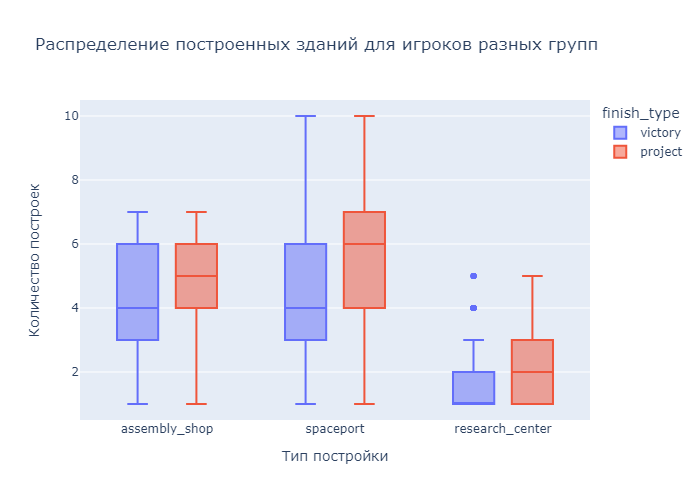

In [15]:
#табличка для графика
plot_df = (finished_users.query('event == "building"')
           .groupby(['user_id', 'building_type', 'finish_type'])['event'].agg('count')
           .reset_index())

fig = px.box(plot_df, x="building_type", y="event", color='finish_type', 
             title="Распределение построенных зданий для игроков разных групп")
fig.update_xaxes(title_text='Тип постройки')
fig.update_yaxes(title_text='Количество построек')

fig.show("png")

In [16]:
print('Количество построек военных')
display(finished_by_victory.query('building_type != "None"')['building_type'].value_counts())

print('Количество построек ученых')
finished_by_project.query('building_type != "None"')['building_type'].value_counts()

Количество построек военных


spaceport          17132
assembly_shop      16298
research_center     3755
Name: building_type, dtype: int64

Количество построек ученых


spaceport          10788
assembly_shop       9116
research_center     3697
Name: building_type, dtype: int64

Назову пользователей, окончивших первый уровень победой над первым противником - военными, а те, кто закончил через проект - учеными.

Для упрощения выводов)

**Выводы**

* Несмотря на то, что пользователи заканчивали уровень разными путями, пользователи из группы военных строили примерно такое же количество исследовательских центров, что и группа ученых (~3700 построек). При этом группа военных строила больше космопортов и сборочных цехов (17100 и 16300 против 10800 и 9100 у группы ученых). Стоит учитывать, что группа военных больше (3951), чем группа ученых (1866).
* Если смотреть на графики количества построек по группам, то по медианным значениям оказывается, что: 
    * на одного ученого пришлось по 2 исследовательских центра, 6 космопортов и 5 сборочных цехов 
    * на одного военного пришлось всего 1 научный центр, по 4 космопорта и 4 сборочных цеха
* Таким образом, оказывается, что ученые в среднем строят даже больше построек, чем военные. Самая большая разница, прежде всего, в количестве исследовательских центров (2 у ученых и 1 у военных, по медианным значениям) 

### Какие источники привлекают больше всего пользователей

Посмотрим, какие источники привлекли больше всего пользователей и оказались наиболее выгодными в расчёте привлечения одного пользователя

In [17]:
pie_plot = user_source.groupby('source', as_index=False)['user_id'].count().rename(columns={'user_id':'users_cnt'})

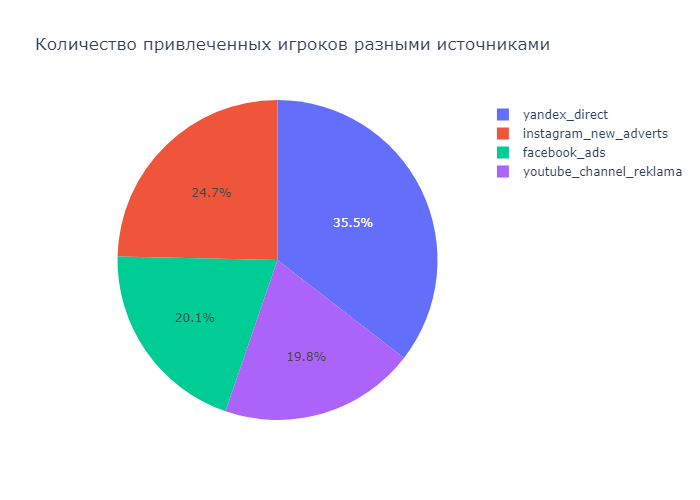

In [18]:
fig = px.pie(pie_plot, values='users_cnt', names='source', title="Количество привлеченных игроков разными источниками")
fig.show("png")

In [19]:
pie_plot.sort_values(by='users_cnt', ascending=False)

,source,users_cnt
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


In [20]:
#присоединяю таблицу с расходами на рекламу
source_cost = pie_plot.merge(ad_costs.groupby('source', as_index=False)['cost'].sum(), on='source')

#расчёт стоимости привлечения одного игрока
source_cost['one_user_cost'] = round(source_cost['cost'] / source_cost['users_cnt'], 1)
source_cost.sort_values(by='one_user_cost')

,source,users_cnt,cost,one_user_cost
3,youtube_channel_reklama,2686,1068.119204,0.4
2,yandex_direct,4817,2233.111449,0.5
1,instagram_new_adverts,3347,2161.441691,0.6
0,facebook_ads,2726,2140.904643,0.8


**Выводы**

* Больше всего пользователей пришло из источников `yandex_direct` (4817) и `instagram_new_adverts` (3347). На 3 и 4 местах `facebook_ads` (2726) и `youtube_channel_reklama` (2686).
* Если брать в расчёт стоимость привлечения пользователей, то стоимость привлечения одного клиента меньше всего у источников `youtube_channel_reklama` (0.4 ед.на клиента) и `yandex_direct` (0.5 ед.на клиента)

## Расчёт прибыли для модели показа рекламы на экране выбора постройки

### Расчёт прибыли с рекламы при её показе на каждом экране постройки

Рассчитаем прибыльность показа рекламы при учёте стоимости одного показа в 0.07 единиц

In [21]:
#к таблице game_actions присоединяю таблицу с источником привлечения игрока
user_source_action = game_actions.merge(user_source, how='left', on='user_id')
user_source_action['income'] = 0.07

#поменяю datetime на date для упрощения анализа
user_source_action['event_datetime'] = user_source_action['event_datetime'].dt.date

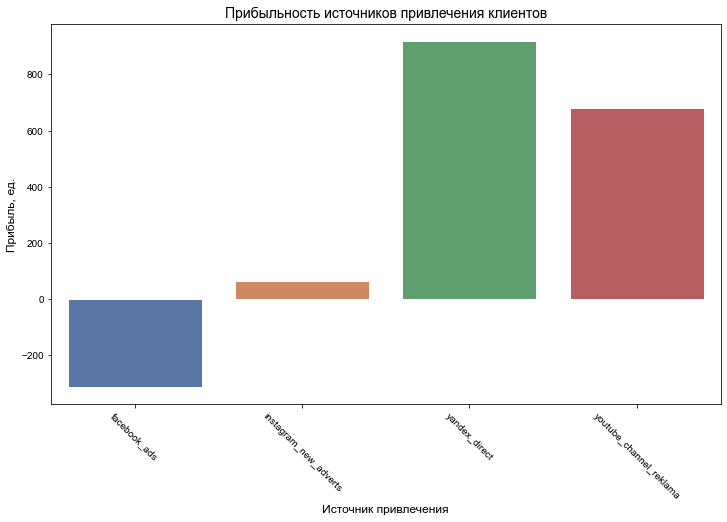

In [22]:
#создаю таблицу для расчёта прибыльности разных источников привлечения игроков
profit_cost = (user_source_action.query('event == "building"').groupby('source', as_index=False)['income'].sum()
               .merge(source_cost[['source', 'cost']], on='source'))
profit_cost['profit'] =  round(profit_cost['income'] - profit_cost['cost'])

#график
fig, ax = plt.subplots(figsize=(12,7))
sns.set(font_scale = 1.1)
sns.set_style("darkgrid")
plt.xticks(rotation=-45)

sns.barplot(data=profit_cost, x='source', y='profit', ax=ax)
ax.set_xlabel('Источник привлечения', fontsize = 12)
ax.set_ylabel('Прибыль, ед.', fontsize = 12)
ax.set_title('Прибыльность источников привлечения клиентов', fontsize = 14)

plt.show()

In [23]:
profit_cost

,source,income,cost,profit
0,facebook_ads,1829.17,2140.904643,-312.0
1,instagram_new_adverts,2227.05,2161.441691,66.0
2,yandex_direct,3152.24,2233.111449,919.0
3,youtube_channel_reklama,1748.46,1068.119204,680.0


In [24]:
round(profit_cost['profit'].sum(), 2)

1353.0

**Выводы**

* Больше всего средств принесли пользователи, пришедшие с источников `yandex_direct` (919 ед.) и `youtube_channel_reklama` (680 ед.)
* Единственным убыточным источником стал `facebook_ads` (-312 ед.)
* Общая прибыль со всех источников за исследуемый период составила 1353 ед. 

### Расчёт прибыли с рекламы при её показе, начиная со второй постройки

Снова рассчитаем прибыльность показа рекламы при учёте стоимости одного показа в 0.07 единиц, но на этот раз при условии, что реклама начнёт показываться со второй постройки.

Для этого сгруппирую по `user_id` и подсчитаю количество построек, вычту из него 1  постройки и затем сделаю фильтр, чтобы это количество было больше 0. Затем всё, как в предыдущем расчёте.

In [25]:
profit_cost_2  = (user_source_action.query('event == "building"')
                  .groupby('user_id', as_index=False)['event'].count())

profit_cost_2['event'] = profit_cost_2['event'] - 1
profit_cost_2 = profit_cost_2.query('event > 0').rename(columns={'event':'building_cnt'})

#находим доход с пользователя
profit_cost_2['income'] = profit_cost_2['building_cnt'] * 0.07 

#присоединям таблицу с источником, который привлёк игрока 
profit_cost_2 = profit_cost_2.merge(user_source, on='user_id') 
profit_cost_2 = profit_cost_2.groupby('source', as_index=False)['income'].sum()

#присоединям таблицу с источником и стоимостью рекламы
profit_cost_2 = profit_cost_2.merge(source_cost[['source', 'cost']], on='source') 

#считаем прибыль, которую принесли игроки, привлеченные разными источниками
profit_cost_2['profit'] = round(profit_cost_2['income'] - profit_cost_2['cost']) 

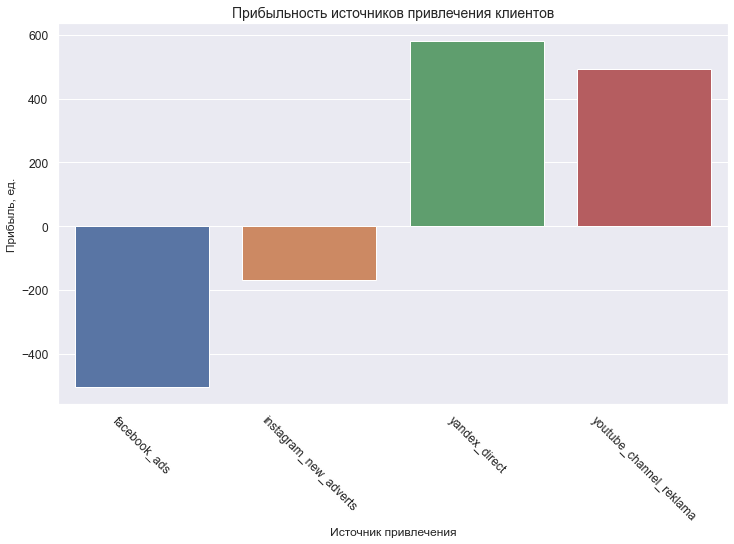

In [26]:
#график
fig, ax = plt.subplots(figsize=(12,7))
sns.set(font_scale = 1.1)
sns.set_style("darkgrid")
plt.xticks(rotation=-45)

sns.barplot(data=profit_cost_2, x='source', y='profit', ax=ax)
ax.set_xlabel('Источник привлечения', fontsize = 12)
ax.set_ylabel('Прибыль, ед.', fontsize = 12)
ax.set_title('Прибыльность источников привлечения клиентов', fontsize = 14)

plt.show()

In [27]:
profit_cost_2

,source,income,cost,profit
0,facebook_ads,1638.35,2140.904643,-503.0
1,instagram_new_adverts,1992.76,2161.441691,-169.0
2,yandex_direct,2815.05,2233.111449,582.0
3,youtube_channel_reklama,1560.44,1068.119204,492.0


In [28]:
round(profit_cost_2['profit'].sum(), 2)

402.0

Чтобы удостовериться, что показ рекламы со второй постройки это граничное значение для прибыльности рекламы, посмотрим ещё на модель показа рекламы с 3 постройки:

In [29]:
profit_cost_3  = (user_source_action.query('event == "building"')
                  .groupby('user_id', as_index=False)['event'].count())

profit_cost_3['event'] = profit_cost_3['event'] - 2
profit_cost_3 = profit_cost_3.query('event > 0').rename(columns={'event':'building_cnt'})

#находим доход с пользователя
profit_cost_3['income'] = profit_cost_3['building_cnt'] * 0.07 

#присоединям таблицу с источником, который привлёк игрока 
profit_cost_3 = profit_cost_3.merge(user_source, on='user_id') 
profit_cost_3 = profit_cost_3.groupby('source', as_index=False)['income'].sum()

#присоединям таблицу с источником и стоимостью рекламы
profit_cost_3 = profit_cost_3.merge(source_cost[['source', 'cost']], on='source') 

#считаем прибыль, которую принесли игроки, привлеченные разными источниками
profit_cost_3['profit'] = round(profit_cost_3['income'] - profit_cost_3['cost']) 

In [30]:
profit_cost_3

,source,income,cost,profit
0,facebook_ads,1448.51,2140.904643,-692.0
1,instagram_new_adverts,1759.24,2161.441691,-402.0
2,yandex_direct,2479.19,2233.111449,246.0
3,youtube_channel_reklama,1373.33,1068.119204,305.0


In [31]:
round(profit_cost_3['profit'].sum(), 2)

-543.0

Действительно, мы уходим в убыток при такой модели

**Выводы**

* При показе рекламы, начиная со второй постройки два источника ушли в убыток `facebook_ads` (-503 ед.) и `instagram_new_adverts` (-169 ед.), два источника принесли прибыль `yandex_direct` (582 ед.) и `youtube_channel_reklama` (492 ед.)
* Общая прибыль за исследуемый период составила - 402 ед.
* Можно заметить, насколько сильно упала общая прибыль при показе рекламы, начиная со второй постройки (1353 ед. при показе с первой постройки и 402 ед. при показе со второй постройки соответственно). Таким образом -показ рекламы со второй постройки является пограничным значением, при показе рекламы с 3 постройки мы уже уйдем в убыток (что показано выше). 

## Проверка гипотез

### Гипотеза о различии времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком

**Нулевая гипотеза** - Среднее время прохождения уровня игроками из групп военных и ученых не отличается

**Альтернативная гипотеза** - Среднее время прохождения уровня игроками из групп военных и ученых отличается

**Критический уровень значимости (альфа)** - 0.05

In [32]:
#выделяю первое и последнее событие для каждого игрока и нахожу разницу во времени между ними
hypothesis_1 = finished_users.groupby('user_id')['event_datetime'].agg(['first', 'last'])
hypothesis_1['time_diff'] = hypothesis_1['last'] - hypothesis_1['first']

#присоединяю столбец с типом завершения уровня
hypothesis_1 = hypothesis_1.merge(finished_users[['user_id','finish_type']], on='user_id').drop_duplicates()

#перевожу разницу во времени в секунды, чтобы можно было провести ttest
hypothesis_1['time_diff'] = hypothesis_1['time_diff'].dt.total_seconds()
hypothesis_1.head()

,user_id,first,last,time_diff,finish_type
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,556722.0,victory
9,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,1084605.0,victory
18,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,1104605.0,victory
31,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,977192.0,victory
40,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,525532.0,victory


Посмотрим, сколько требуется времени для завершения уровня игрокам из группы военных и ученых

In [33]:
hypothesis_1_grouped = hypothesis_1.groupby('finish_type', as_index=False)['time_diff'].agg('median')
hypothesis_1_grouped['time_diff'] = hypothesis_1_grouped['time_diff'] / 3600
hypothesis_1_grouped

,finish_type,time_diff
0,project,312.761389
1,victory,259.026944


Можем заметить, что время прохождения у игроков разных групп отличается. Игроки, завершающие через победу проходят уровень быстрее, а такого в идеале быть не должно. В идеале среднее время прохождения уровня между игроками разных групп должно отличаться незначительно, чтобы в игре был баланс между различными способами прохождения уровня, иначе вариант более быстрого прохождения будет становится всё более популярным, а другой вариант начнёт потихоньку вымирать.

In [34]:
victory_group = hypothesis_1.query('finish_type == "victory"')['time_diff']
project_group = hypothesis_1.query('finish_type == "project"')['time_diff']

alpha = .05

results = st.ttest_ind(victory_group, project_group)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.256845329495443e-98
Отвергаем нулевую гипотезу


**Выводы**

Отвергаем гипотезу о равенстве среднего времени прохождения уровня, так как p-value ниже критического уровня значимости (который мы задали равным 0.05).

Таким образом подтвердилась альтернативная гипотеза о неравенстве среднего времени прохождения уровня между игроками разных групп.

### Гипотеза о различии дохода с пользователей, привлеченных источниками facebook_ads и youtube_channel_reklama

**Нулевая гипотеза** - Средний доход с игроков, привлеченных источниками facebook_ads и youtube_channel_reklama не отличается

**Альтернативная гипотеза** - Средний доход с игроков, привлеченных источниками facebook_ads и youtube_channel_reklama различается

**Критический уровень значимости (альфа)** - 0.05

In [35]:
#создание таблички с доходами от рекламы с игроков, привлеченных разными источниками, так же необходимо для проведения ttest
profit_cost_  = (user_source_action.query('event == "building"')
                  .groupby('user_id', as_index=False)['event'].count())

profit_cost_ = profit_cost_.rename(columns={'event':'building_cnt'})
profit_cost_['income'] = profit_cost_['building_cnt'] * 0.07
profit_cost_ = profit_cost_.merge(user_source, on='user_id')

profit_cost_.groupby('source', as_index=False)['income'].sum()

,source,income
0,facebook_ads,1829.17
1,instagram_new_adverts,2227.05
2,yandex_direct,3152.24
3,youtube_channel_reklama,1748.46


Доход с игроков, привлеченных источниками `facebook_ads` и `youtube_channel_reklama` различается незначительно (1829 ед. и 1748 ед. соответственно)

In [36]:
facebook = profit_cost_.query('source == "facebook_ads"')['income']
youtube = profit_cost_.query('source == "youtube_channel_reklama"')['income']

alpha = .05

results = st.ttest_ind(facebook, youtube)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.006588846148210699
Отвергаем нулевую гипотезу


**Выводы**

Отвергаем гипотезу о равенстве дохода с пользователей, привлеченных источниками `facebook_ads` и `youtube_channel_reklama`, так как p-value ниже критического уровня значимости (который мы задали равным 0.05).

Таким образом подтвердилась альтернативная гипотеза о неравенстве дохода с пользователей, привлеченных разными источниками. Хотя сами значения дохода с двух источников различались незначительно, но статистически эта разница имеется.

## Выводы и рекомендации по проекту

### Выводы

* Большинство пользователей заканчивают уровень через победу над первым противником, таких пользователей 68% от общего числа успешно завершивших первый уровень.
* Оказалось, что игроки из групп военных и ученых строят примерно одинаковое количество зданий (группа ученых в среднем строят даже больше). При этом значимое различие только в количестве построенных исследовательских центров (2 у ученых и 1 у военных, по медианным значениям)
* Больше всего пользователей пришло из источников `yandex_direct` (4817) и `instagram_new_adverts` (3347). На 3 и 4 местах `facebook_ads` (2726) и `youtube_channel_reklama` (2686).
* Для модели показа рекламы на каждом экране постройки - наибольшую прибыль принесли пользователи, пришедшие с источников `yandex_direct` (919 ед.) и `youtube_channel_reklama` (680 ед.). Общая прибыль составила за исследуемый период составила 1353 ед.
* При показе рекламы, начиная со второй постройки два источника ушли в убыток: `facebook_ads`(-503 ед.) и `instagram_new_adverts` (-169 ед.) и два источника принесли прибыль `yandex_direct` (582 ед.) и `youtube_channel_reklama` (492 ед.). Общая прибыль за исследуемый период составила - 402 ед.
* Границей прибыльности при показе рекламы на экране постройки является её показ со второй постройки, при показе рекламы с третьей постройки мы уже уходим в убыток.
* Проверки гипотез показали, что среднее время прохождения первого уровня между игроками из групп, закончивших первой победой или проектом, статистически значительно различается, геймдизайнерам стоит обратить внимание на исправление этого момента, чтобы группы пвп и пве проводили примерно одинаковое время в игре. Так же мы выяснили, что доход с пользователей, привлеченных источниками `facebook_ads` и `youtube_channel_reklama` так же статистически различается.

### Рекомендации

Можно сказать, что введение рекламы на экране постройки, начиная со второго здания является наиболее оптимальной моделью. Мы не уходим в убыток, в то же время рекламная нагрузка на пользователей меньше, чем при показе рекламы на каждом экране с выбором постройки. 